In [1]:
from random import randint
from collections import defaultdict
from uuid import uuid4
from dataclasses import dataclass
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipynb.fs.full.Observer import RemoteCamera, CaptureMachine, TrackedObject, CaptureConfiguration, \
    Camera, hStackImages, vStackImages, cameras, ChangeSet, RealSpaceConverter
import dma.MechaCombat as mc
QuantumSystem = mc.QuantumSystem

In [2]:
@dataclass
class QuantumObject(TrackedObject):
    name: str
    objectType: str

    def __eq__(self, other):
        return super().__eq__(other)
    
    def __post_init__(self):
        super().__post_init__()
        self.qid = str(uuid4())

    def previousVersion(self):
        return type(self)({camNum: change.lastChange if change is not None else None for camNum, change in self.changeSet.items()}, self.name, self.objectType)

    def __repr__(self):
        changeSet = {camNum: cS for camNum, cS in self.changeSet.items() if cS is not None and cS.changeType not in [None, 'delete']}
        return f"QO - {self.objectType} - {self.name} ({changeSet})"

In [3]:
@dataclass
class HarmonyCamera(RemoteCamera):
    camType: str = "field"

    knownCameraTypes = ["field", "dice"]
    
    def collectDiceRoll(self):
        assert self.camType == "dice", "Only dice cameras can collect dice rolls"
        src = self.cropToActiveZone(self.collectImage())
    
        # Assuming src is your source image
        gray = cv2.cvtColor(src, cv2.COLOR_RGBA2GRAY)
    
        pixelHist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        total = pixelHist[1:].sum()
        cumsum = 0
        for i, v in enumerate(pixelHist[::-1]):
            cumsum += v[0]
            if (cumsum / total) > 0.015:
                break
        threshold = 255 - i
        _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
        
        # Find contours
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter contours based on appropriate size to identify the pips
        total = len(contours)
        pipCnt = []
        areas = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            x, y, w, h = cv2.boundingRect(cnt)
            areas.append(area)
            if 500 < area < 7000 and w * 0.5 < h < w * 1.5:
                pipCnt.append(cnt)
        return len(pipCnt)

In [4]:
class HarmonyConfiguration(CaptureConfiguration):
    def capture(self):
        self.lastCapture = {cam.camName: cam.capture() for cam in cameras.values() if cam is not None and cam.camType == 'field'}

    def collectDiceRoll(self):
        diceCam = [cam for cam in cameras.values() if cam.camType == "dice"][0]
        lastRoll = None
        attempts = 0
        while (roll := diceCam.collectDiceRoll()) != lastRoll and attempts < 5:
            lastRoll = roll
            attempts += 1
        if lastRoll != roll:
            raise Exception("Unable to collect dice roll")
        return roll

    def loadConfiguration(self):
        try:
            with open("observerConfiguration.json", "r") as f:
                config = json.loads(f.read())
        except:
            print("Failed to open Observer Configuration!")
            ## TODO: Default configuration if file not found
            raise

        for camName, camDef in config.items():
            if str(camName) in ["pov", "dice"]:
                global pov
                addr = camDef['addr']
                rot = camDef['rot']
                pov = HarmonyCamera(address=addr, rotate=rot, activeZone=[], camName="pov", camType="dice")
            elif str(camName) == "rsc":
                if camDef is None:
                    continue
                else:
                    self.rsc = [
                        [cN, [[np.array(pt, dtype="int32") for pt in cL] for cL in coordList]]
                        for cN, coordList in camDef]
                    self.rsc = RealSpaceConverter(self.rsc)
            elif str(camName) == "calibrationPlan":
                self.calibrationPlan = camDef
            else:
                addr = camDef['addr']
                rot = camDef['rot']
                az = np.float32(json.loads(camDef['az']))
                ct = camDef.get('camType', 'field')
                cameras[camName] = HarmonyCamera(address=addr, activeZone=az, camName=camName, camType=ct)
    
    def jsonConfiguration(self):
        state = {
            camName: {
                "addr": cam.address,
                "rot": cam.rotate,
                "az": json.dumps(cam.activeZone.tolist()),
                "camType": cam.camType}
            for camName, cam in cameras.items()}
        if self.rsc is not None:
            state["rsc"] = [[cN, [[a.tolist() if type(a) != list else a for a in coordList[0]], [a.tolist() if type(a) != list else a for a in coordList[1]]]]
                            for cN, coordList in self.rsc.realCamSpacePairs]
        else:
            state["rsc"] = None
        state["calibrationPlan"] = self.calibrationPlan
        return json.dumps(state, indent=2)

In [5]:
class HarmonyMachine(CaptureMachine):
    states = ["idle", "unstable", "classify", "illegal"]
    modes = ["passive", "calibrate", "add", "move", "action"]
    actionStates = ["sel0", "sel1", "confirm", "roll"]
    MM_FOR_MOVE = 15

    def __init__(self, config: HarmonyConfiguration):
        super().__init__(config)
        self.hc = self.cc
        mc.qs.reset()
        self.newObjectBuffer = []
        self.selectedObjects = []
        self.mode = "passive"
        self.actionState = "sel0"
        self.diceRoll = None
        
    def referenceFrameDeltas(self):
        return ChangeSet({camName: cam.referenceFrameDelta() for camName, cam in cameras.items() if cam.camType == 'field'})
    
    def isLegal(self, classifiedChange):
        return True
        
    def storeNewObject(self, objDef):
        self.lastMemory = objDef
        if not objDef.isNewObject:
            existingIndex = self.newObjectBuffer.index(objDef.previousVersion())
            existingObj = self.newObjectBuffer[existingIndex]
            existingObj.update(objDef, overwrite=self.cc.rsc.trackedObjectLastDistance(objDef) > self.MM_FOR_MOVE)
        else:
            self.newObjectBuffer.append(objDef)
        
        for camNum, change in objDef.changeSet.items():
            cameras[camNum].commitChange(change)
        
        self.transitions.append({
            "obj": objDef,
            "cycle": self.cycleCounter,
            "cameraChanges":  {camNum: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
                               for camNum, cam in cameras.items()}})
    
    def commitChanges(self, objDef):
        try:
            existingIndex = self.memory.index(objDef.previousVersion())
            existingObj = self.memory[existingIndex]
            print(f"Updating Memory {existingIndex}")
            existingObj.update(objDef, overwrite=self.cc.rsc.trackedObjectLastDistance(objDef) > self.MM_FOR_MOVE)
        except Exception:
            raise Exception("Cannot commit to unrecognized memory")
        self.lastMemory = existingObj
        
        for camNum, change in objDef.changeSet.items():
            cameras[camNum].commitChange(change)

        self.transitions.append({
            "obj": objDef,
            "cycle": self.cycleCounter,
            "cameraChanges":  {camNum: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
                               for camNum, cam in cameras.items()}})

    def annotateObject(self, oid, objName, objType):
        caps = {cap.oid: cap for cap in self.newObjectBuffer}
        cap = caps[oid]
        center = self.cc.rsc.changeSetToRealCenter(cap)
        qObj = QuantumObject(cap.changeSet, objName, objType)
        factory = mc.ObjectFactories[objType]
        factory(objName, "Unaligned")
        mc.XYLocation.set_location(objName, json.dumps(list(center) + [0]))
        self.memory.append(qObj)
        self.newObjectBuffer.remove(cap)
    
    def cycle(self):
        try:
            print(f"Starting Cycle {self.cycleCounter:5} -- {self}" + '' if self.state != "action" else f" {self.actionState}")
            self.cycleCounter += 1
            nextState = "idle"
            self.hc.capture()
            if self.mode == "passive":
                self.hc.setReference()
                return
            elif self.actionState in ["confirm", "roll"]:
                # Test Legality of Attack between sO[0] -> sO[1]
                # if not legal: 
                    # self.selectedObjects = []
                    # self.actionState = "sel0"
                # Calculate SATOR for Attack
                self.targetRoll = 7
                  # Wait for confirmation by Dice Roll going to 0
                roll = self.hc.collectDiceRoll()
                if self.actionState == "confirm" and roll == 0:
                    self.actionState = "roll"
                    print(f"Waiting for dice roll: {self.actionState}")
                elif self.actionState == "roll" and roll != 0:
                    self.diceRoll = 7
                    if roll > self.targetRoll:
                        print(f"Dice roll success: {roll}")
                        pass
                    else:
                        print(f"Dice roll failure: {roll}")
                        pass
                    self.actionState="sel0"
                else:
                    print(f"Waiting for confirmation: {roll}")
            # else: mode in ["calibrate", "add", "move", "attack"]
            
            changes = self.referenceFrameDeltas()
            classification = None

            if changes.empty and self.state == "idle":
                self.hc.setReference()
            elif not changes.empty:
                nextState = "unstable"
                if self.state in ["unstable", "classify"] and changes == self.lastChanges:  # TODO: and cameraChangeOverlap
                    classification = self.classifyChanges(changes)
                    nextState = "classify"
                    if self.state == "classify":
                        if self.mode in ["move", "action"]:
                            assert not classification.isNewObject, f"Cannot add objects in {self.mode}"
                            if self.mode == "move":
                                assert self.isLegal(classification), f"{classificaton} is an illegal move"
                            elif self.mode == "action":
                                assert (lastDist := self.cc.rsc.trackedObjectLastDistance(classification)) < self.MM_FOR_MOVE, f"{classification} moves too far ({lastDist}) for selection"
                                
                            nextState = "idle"
                            print("Committing classification")
                            self.commitChanges(classification)
                            if self.mode == "action":
                                if len(self.selectedObjects) == 2:
                                    self.selectedObjects = [self.lastMemory]
                                    self.actionState = "sel1"
                                else:
                                    self.selectedObjects.append(self.lastMemory)
                                    self.actionState = "sel1" if len(self.selectedObjects) == 1 else "confirm"
                                print(f"Selected Objects: {self.selectedObjects}")
                            self.hc.setReference()
                        elif self.mode == "add":
                            nextState = "idle"
                            self.storeNewObject(classification)
                            self.hc.setReference()
                        elif self.mode == "calibrate":
                            try:
                                self.calibrateToObject(classification)
                            except AssertionError as ae:
                                print(f"Failed Calibration: {ae}")
                            nextState = "idle"
                            self.hc.setReference()
                        else:
                            raise Exception("Unrecognized State")
            self.state = nextState
            self.lastChanges = changes
            self.lastClassification = classification
        except:
            from traceback import format_exc
            print("CYCLE FAILURE!!!")
            print(format_exc())
            if self.mode == "action":
                from IPython import embed; embed()
            self.state = "unstable"
            self.lastChanges = None
            self.lastClassification = None
    
    def actionMode(self):
        self.selectedObjects = []
        self.mode = "action"
        self.actionState = "sel0"
    
    def moveMode(self):
        self.mode = "move"
    
    def addMode(self):
        self.mode = "add"
    
    def passiveMode(self):
        self.mode = "passive"
    
    def startCalibration(self):
        self.calibrationPts = []
        self.mode = "calibrate"
    
    def abortCalibration(self):
        self.calibrationPts = []
        self.mode = "passive"
            
    def cycleForAddition(self):
        self.mode = "add"
        startLen = len(self.newObjectBuffer)
        while len(self.newObjectBuffer) == startLen:
            self.cycle()
        self.mode = "idle"
        return self.newObjectBuffer[-1]
            
    def cycleForMove(self):
        self.mode = "move"
        startLen = len(self.transitions)
        while len(self.transitions) == startLen:
            self.cycle()
        self.mode = "idle"
        return self.lastMemory
            
    def cycleForAction(self):
        self.mode = "action"
        self.actionState = "sel0"
        self.diceRoll = None
        while self.diceRoll is None:
            self.cycle()
        self.mode = "idle"
        return self.lastMemory
            
    def __repr__(self):
        return f"CapMac -- {self.mode} {str(len(self.calibrationPts)) + ' ' if self.mode == 'calibrate' else ''}{self.state} - {self.actionState}"

In [6]:
print("Building Harmony Machine")
cc = HarmonyConfiguration()
cm = HarmonyMachine(cc)

Building Harmony Machine


8


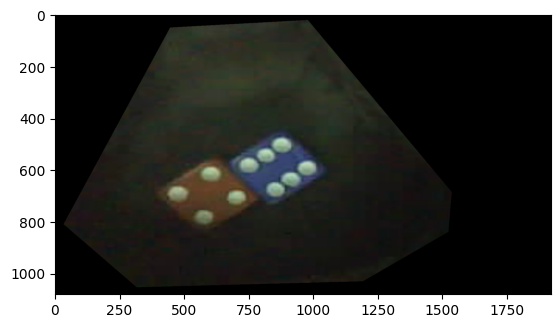

In [7]:
if __name__ == "__main__":
    print(cameras['Dice'].collectDiceRoll())
    plt.imshow(cameras['Dice'].cropToActiveZone(cameras['Dice'].mostRecentFrame))

In [8]:
if __name__ == "__main__" and False:
    cm.cycleForCalibration()
    for camName, cons in cc.rsc.converters.items():
        if len(cons) == 1:
            plt.imshow(cons[0].showUnwarpedImage())
        else:
            fig, axes = plt.subplots(1, len(cons))
            for ax, c in zip(axes, cons):
                ax.imshow(c.showUnwarpedImage())
        plt.title(f"{camName} Unwarped")
        plt.show()
    cc.saveConfiguration()

Waiting for object...
Starting Cycle     0 -- CapMac -- add idle - sel0
Starting Cycle     1 -- CapMac -- add idle - sel0
Starting Cycle     2 -- CapMac -- add idle - sel0
Starting Cycle     3 -- CapMac -- add idle - sel0
Starting Cycle     4 -- CapMac -- add idle - sel0
Starting Cycle     5 -- CapMac -- add idle - sel0
Starting Cycle     6 -- CapMac -- add idle - sel0
Starting Cycle     7 -- CapMac -- add idle - sel0
Starting Cycle     8 -- CapMac -- add idle - sel0
Starting Cycle     9 -- CapMac -- add idle - sel0
Starting Cycle    10 -- CapMac -- add idle - sel0
Starting Cycle    11 -- CapMac -- add idle - sel0
Starting Cycle    12 -- CapMac -- add idle - sel0
Starting Cycle    13 -- CapMac -- add unstable - sel0
Starting Cycle    14 -- CapMac -- add unstable - sel0
Starting Cycle    15 -- CapMac -- add unstable - sel0
Starting Cycle    16 -- CapMac -- add classify - sel0
Cam 0 - Adding (add) [873.0, 337.0] by 83.0,88.0


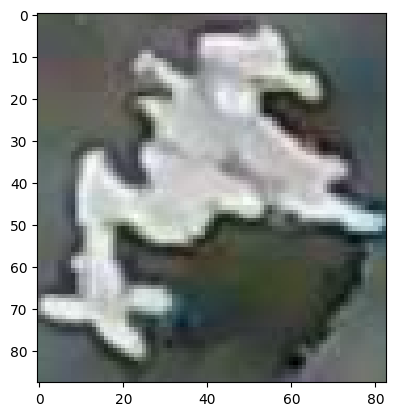

Waiting for object...
Starting Cycle    17 -- CapMac -- add idle - sel0
Starting Cycle    18 -- CapMac -- add idle - sel0
Starting Cycle    19 -- CapMac -- add idle - sel0
Starting Cycle    20 -- CapMac -- add idle - sel0
Starting Cycle    21 -- CapMac -- add idle - sel0
Starting Cycle    22 -- CapMac -- add idle - sel0
Starting Cycle    23 -- CapMac -- add idle - sel0
Starting Cycle    24 -- CapMac -- add idle - sel0
Starting Cycle    25 -- CapMac -- add idle - sel0
Starting Cycle    26 -- CapMac -- add idle - sel0
Starting Cycle    27 -- CapMac -- add idle - sel0
Starting Cycle    28 -- CapMac -- add idle - sel0
Starting Cycle    29 -- CapMac -- add idle - sel0
Starting Cycle    30 -- CapMac -- add idle - sel0
Starting Cycle    31 -- CapMac -- add unstable - sel0
Starting Cycle    32 -- CapMac -- add unstable - sel0
Starting Cycle    33 -- CapMac -- add unstable - sel0
Starting Cycle    34 -- CapMac -- add classify - sel0
Cam 0 - Adding (add) [601.0, 430.0] by 82.0,108.0


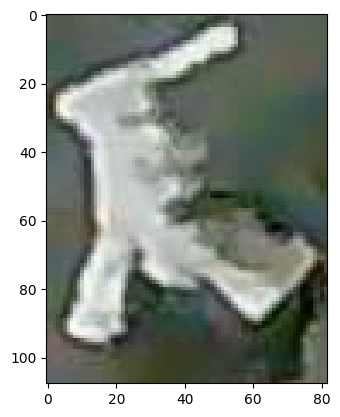

In [9]:
if __name__ == "__main__":
    for i in range(3):
        cm.cc.capture()
    for i in range(2):
        print("Waiting for object...")
        obj = cm.cycleForAddition()
        cm.annotateObject(obj.oid, f"Foo{i}", "Huntsman")
        plt.imshow(obj.visual())
        plt.show()

Waiting for movement
Starting Cycle    35 -- CapMac -- move idle - sel0
Starting Cycle    36 -- CapMac -- move idle - sel0
Starting Cycle    37 -- CapMac -- move idle - sel0
Starting Cycle    38 -- CapMac -- move idle - sel0
Starting Cycle    39 -- CapMac -- move idle - sel0
Starting Cycle    40 -- CapMac -- move idle - sel0
Starting Cycle    41 -- CapMac -- move idle - sel0
Starting Cycle    42 -- CapMac -- move idle - sel0
Starting Cycle    43 -- CapMac -- move unstable - sel0
Starting Cycle    44 -- CapMac -- move unstable - sel0
Starting Cycle    45 -- CapMac -- move unstable - sel0
Starting Cycle    46 -- CapMac -- move classify - sel0
Committing classification
Updating Memory 1
In update: overwrite - True
Cam 0 - Moving (add) [601.0, 430.0] by 82.0,108.0 to (move) [649.0, 500.0] by 87.0,111.0


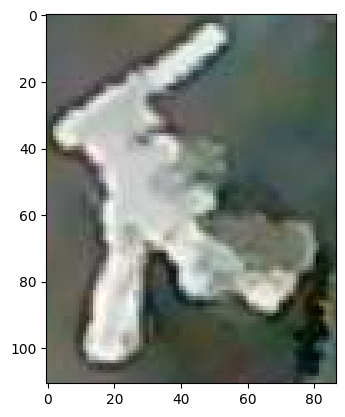

Waiting for movement
Starting Cycle    47 -- CapMac -- move idle - sel0
Starting Cycle    48 -- CapMac -- move idle - sel0
Starting Cycle    49 -- CapMac -- move idle - sel0
Starting Cycle    50 -- CapMac -- move idle - sel0
Starting Cycle    51 -- CapMac -- move idle - sel0
Starting Cycle    52 -- CapMac -- move idle - sel0
Starting Cycle    53 -- CapMac -- move unstable - sel0
Starting Cycle    54 -- CapMac -- move unstable - sel0
Starting Cycle    55 -- CapMac -- move unstable - sel0
Starting Cycle    56 -- CapMac -- move classify - sel0
Committing classification
Updating Memory 0
In update: overwrite - True
Cam 0 - Moving (add) [873.0, 337.0] by 83.0,88.0 to (move) [782.0, 259.0] by 72.0,78.0


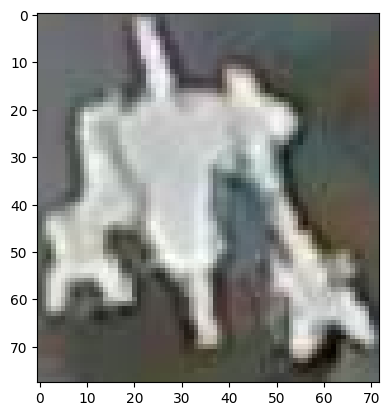

In [10]:
if __name__ == "__main__":
    for i in range(2):
        print("Waiting for movement")
        obj = cm.cycleForMove()
        plt.imshow(obj.visual())
        plt.show()

Starting Cycle    57 -- CapMac -- action idle - sel0
Starting Cycle    58 -- CapMac -- action idle - sel0
Starting Cycle    59 -- CapMac -- action idle - sel0
Starting Cycle    60 -- CapMac -- action idle - sel0
Starting Cycle    61 -- CapMac -- action idle - sel0
Starting Cycle    62 -- CapMac -- action idle - sel0
Starting Cycle    63 -- CapMac -- action idle - sel0
Starting Cycle    64 -- CapMac -- action idle - sel0
Starting Cycle    65 -- CapMac -- action idle - sel0
Starting Cycle    66 -- CapMac -- action idle - sel0
Starting Cycle    67 -- CapMac -- action idle - sel0
Starting Cycle    68 -- CapMac -- action idle - sel0
Starting Cycle    69 -- CapMac -- action idle - sel0
Starting Cycle    70 -- CapMac -- action unstable - sel0
Starting Cycle    71 -- CapMac -- action unstable - sel0
Starting Cycle    72 -- CapMac -- action unstable - sel0
Starting Cycle    73 -- CapMac -- action classify - sel0
Committing classification
Updating Memory 1
In update: overwrite - False
Cam 0 - Mo

In [1]:  exit



Starting Cycle    91 -- CapMac -- action unstable - sel1
Starting Cycle    92 -- CapMac -- action unstable - sel1
Starting Cycle    93 -- CapMac -- action classify - sel1
Committing classification
Updating Memory 0
In update: overwrite - False
Cam 0 - Moving (move) [782.0, 259.0] by 72.0,78.0 to (move) [781.0, 263.0] by 72.0,76.0
Selected Objects: [QO - Huntsman - Foo1 ({'0': (move) [638.0, 503.0] by 90.0,113.0}), QO - Huntsman - Foo0 ({'0': (move) [781.0, 263.0] by 72.0,76.0})]
Starting Cycle    94 -- CapMac -- action idle - confirm
CYCLE FAILURE!!!
Traceback (most recent call last):
  File "/tmp/ipykernel_59491/2505020302.py", line 88, in cycle
    roll = self.hc.collectDiceRoll()
  File "/tmp/ipykernel_59491/687865118.py", line 13, in collectDiceRoll
    raise Exception("Unable to collect dice roll")
Exception: Unable to collect dice roll

Python 3.9.2 (default, Feb 28 2021, 17:03:44) 
Type 'copyright', 'credits' or 'license' for more information
IPython 8.14.0 -- An enhanced Inter

In [1]:  exit



Starting Cycle    95 -- CapMac -- action unstable - confirm
Waiting for confirmation: 9
Starting Cycle    96 -- CapMac -- action idle - confirm
Waiting for confirmation: 9
Starting Cycle    97 -- CapMac -- action idle - confirm
CYCLE FAILURE!!!
Traceback (most recent call last):
  File "/tmp/ipykernel_59491/2505020302.py", line 88, in cycle
    roll = self.hc.collectDiceRoll()
  File "/tmp/ipykernel_59491/687865118.py", line 13, in collectDiceRoll
    raise Exception("Unable to collect dice roll")
Exception: Unable to collect dice roll

Python 3.9.2 (default, Feb 28 2021, 17:03:44) 
Type 'copyright', 'credits' or 'license' for more information
IPython 8.14.0 -- An enhanced Interactive Python. Type '?' for help.



In [1]:  exit



Starting Cycle    98 -- CapMac -- action unstable - confirm
Waiting for confirmation: 10
Starting Cycle    99 -- CapMac -- action idle - confirm
Waiting for confirmation: 4
Starting Cycle   100 -- CapMac -- action idle - confirm
Waiting for confirmation: 2
Starting Cycle   101 -- CapMac -- action idle - confirm
Waiting for dice roll: roll
Starting Cycle   102 -- CapMac -- action idle - roll
CYCLE FAILURE!!!
Traceback (most recent call last):
  File "/tmp/ipykernel_59491/2505020302.py", line 88, in cycle
    roll = self.hc.collectDiceRoll()
  File "/tmp/ipykernel_59491/687865118.py", line 13, in collectDiceRoll
    raise Exception("Unable to collect dice roll")
Exception: Unable to collect dice roll

Python 3.9.2 (default, Feb 28 2021, 17:03:44) 
Type 'copyright', 'credits' or 'license' for more information
IPython 8.14.0 -- An enhanced Interactive Python. Type '?' for help.



In [1]:  exit



Starting Cycle   103 -- CapMac -- action unstable - roll
Waiting for confirmation: 0
Starting Cycle   104 -- CapMac -- action idle - roll
Waiting for confirmation: 0
Starting Cycle   105 -- CapMac -- action idle - roll
Dice roll failure: 2


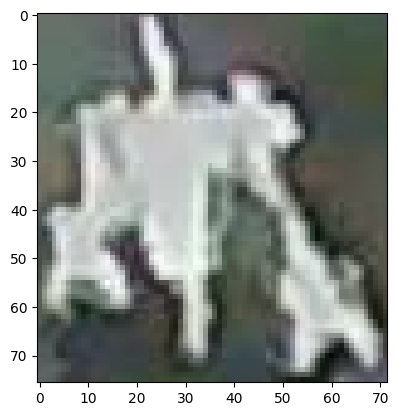

In [11]:
if __name__ == "__main__":
    obj = cm.cycleForAction()
    plt.imshow(obj.visual())
    plt.show()